In [ ]:
!pip install yfinance


In [ ]:
!apt-get update && sudo apt-get install cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [46.8 kB]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,468 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,420 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://ppa.launchpadcont

In [ ]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

check_and_make_directories([TRAINED_MODEL_DIR])

import itertools

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


--------------------------------------------------------------------------------

In [ ]:
config_tickers.DOW_30_TICKER

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [ ]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-29'

In [ ]:
df_raw = YahooDownloader(start_date=TRAIN_START_DATE, end_date=TRADE_END_DATE, ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
df_raw.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.747390,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,43.073925,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.193846,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941082,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.093397,7117200,CAT,4


In [ ]:
INDICATORS

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_vix=True,
    use_turbulence=True,
    user_defined_feature=False
)
df_processed = fe.preprocess_data(df_raw)
df_processed.head()

Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3228, 8)
Successfully added vix
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.747390,746015200,AAPL,4,0.0,2.969344,2.641387,100.0,66.666667,100.0,2.747390,2.747390,39.189999,0.0
1,2009-01-02,58.590000,59.080002,57.750000,43.073925,6547900,AMGN,4,0.0,2.969344,2.641387,100.0,66.666667,100.0,43.073925,43.073925,39.189999,0.0
2,2009-01-02,18.570000,19.520000,18.400000,15.193846,10955700,AXP,4,0.0,2.969344,2.641387,100.0,66.666667,100.0,15.193846,15.193846,39.189999,0.0
3,2009-01-02,42.799999,45.560001,42.779999,33.941082,7010200,BA,4,0.0,2.969344,2.641387,100.0,66.666667,100.0,33.941082,33.941082,39.189999,0.0
4,2009-01-02,44.910000,46.980000,44.709999,31.093397,7117200,CAT,4,0.0,2.969344,2.641387,100.0,66.666667,100.0,31.093397,31.093397,39.189999,0.0


In [ ]:
#FeatureEngineer?

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
list_ticker = df_processed["tic"].unique().tolist()
list_date = list(pd.date_range(df_processed['date'].min(), df_processed['date'].max()).astype(str))
combination = list(itertools.product(list_date, list_ticker))

processed_full = pd.DataFrame(combination, columns=["date","tic"]).merge(df_processed, on=["date","tic"], how="left")
processed_full = processed_full[processed_full['date'].isin(df_processed['date'])]
processed_full = processed_full.sort_values(['date', 'tic'])
processed_full = processed_full.fillna(0)
processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.747390,746015200.0,4.0,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,2.747390,2.747390,39.189999,0.000000
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.073925,6547900.0,4.0,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,43.073925,43.073925,39.189999,0.000000
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.193846,10955700.0,4.0,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,15.193846,15.193846,39.189999,0.000000
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941082,7010200.0,4.0,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,33.941082,33.941082,39.189999,0.000000
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.093397,7117200.0,4.0,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,31.093397,31.093397,39.189999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135773,2021-10-27,UNH,454.640015,460.440002,453.480011,441.170807,3520400.0,2.0,11.345165,451.559700,362.173186,65.085936,174.351046,51.571330,403.881882,404.166421,16.980000,145.284685
135774,2021-10-27,V,224.750000,224.750000,215.660004,212.099319,22958100.0,2.0,0.013795,232.994192,214.822641,41.737186,-153.682205,30.337021,223.018855,225.227714,16.980000,145.284685
135775,2021-10-27,VZ,53.169998,53.200001,52.470001,46.484341,15007400.0,2.0,-0.215912,48.194480,45.191919,44.604893,-50.004200,8.504850,46.923545,47.527330,16.980000,145.284685
135776,2021-10-27,WBA,48.450001,48.459999,47.090000,41.611912,5652000.0,2.0,-0.014509,44.215243,40.487789,46.167766,-62.027270,5.045608,42.551244,42.866391,16.980000,145.284685


In [ ]:
df_train = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
df_test = data_split(processed_full, TRADE_START_DATE, TRADE_END_DATE)
print(len(df_train))
print(len(df_test))

83897
9715


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_train.to_csv("train.csv")
df_test.to_csv("test.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train = pd.read_csv('train.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']
train.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.747390,746015200.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,2.747390,2.747390,39.189999,0.0
0,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.073925,6547900.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,43.073925,43.073925,39.189999,0.0
0,2009-01-02,AXP,18.570000,19.520000,18.400000,15.193846,10955700.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,15.193846,15.193846,39.189999,0.0
0,2009-01-02,BA,42.799999,45.560001,42.779999,33.941082,7010200.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,33.941082,33.941082,39.189999,0.0
0,2009-01-02,CAT,44.910000,46.980000,44.709999,31.093397,7117200.0,4.0,0.0,2.969344,2.641387,100.0,66.666667,100.0,31.093397,31.093397,39.189999,0.0


--------------------------------------------------------------------------------

### **environment**


In [ ]:
stock_dimension = len(df_train.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"stock_dimension : ", stock_dimension, "state_space : ", state_space)

stock_dimension :  29 state_space :  291


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

In [ ]:
env_kwargs = {
  "hmax": 100,
  "initial_amount": 1_000_000,
  "num_stock_shares": num_stock_shares,
  "buy_cost_pct": buy_cost_list,
  "sell_cost_pct": sell_cost_list,
  "state_space": state_space,
  "stock_dim": stock_dimension,
  "tech_indicator_list": INDICATORS,
  "action_space": stock_dimension,
  "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = df_train, **env_kwargs)
#StockTradingEnv?

In [ ]:
env_train,_ = e_train_gym.get_sb_env()
type(env_train)

stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv

--------------------------------------------------------------------------------

### **Agent**

In [ ]:
from stable_baselines3.common.logger import configure

agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ppo = True
if_using_ddpg = True
if_using_td3 = True
if_using_sac = True


### **A2C agent**

In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c", policy="MlpPolicy")

if if_using_a2c:
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [ ]:
trained_a2c = agent.train_model(
    model = model_a2c,
    tb_log_name = 'a2c',
    total_timesteps = 50000
)if if_using_a2c else None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---------------------------------------
| time/                 |             |
|    fps                | 61          |
|    iterations         | 100         |
|    time_elapsed       | 8           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.2       |
|    explained_variance | -2.13       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -39.2       |
|    reward             | -0.25970852 |
|    std                | 1           |
|    value_loss         | 3.93        |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 66          |
|    iterations         | 200         |
|    time_elapsed       | 15          |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -41.2       |
|    explained_variance | 0.286       |


In [ ]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

df_a2c = pd.read_csv("results/a2c/progress.csv")
df_a2c.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,train/policy_loss,time/fps,train/n_updates,time/iterations,train/learning_rate,train/reward,time/time_elapsed,train/std,train/value_loss,time/total_timesteps,train/explained_variance,train/entropy_loss
0,-39.231224,61,99,100,0.0007,-0.259709,8,1.000932,3.931227,500,-2.126416e+00,-41.169819
1,-43.334370,66,199,200,0.0007,-0.480808,15,1.001778,1.702656,1000,2.859024e-01,-41.183769
2,-369.076843,72,299,300,0.0007,7.022842,20,1.000801,81.584625,1500,-1.192093e-07,-41.166260
3,32.334034,66,399,400,0.0007,2.029327,29,0.999761,1.357019,2000,0.000000e+00,-41.135571
4,297.158905,70,499,500,0.0007,-4.709317,35,1.001683,62.584534,2500,1.072884e-06,-41.182278


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='train/n_updates'>

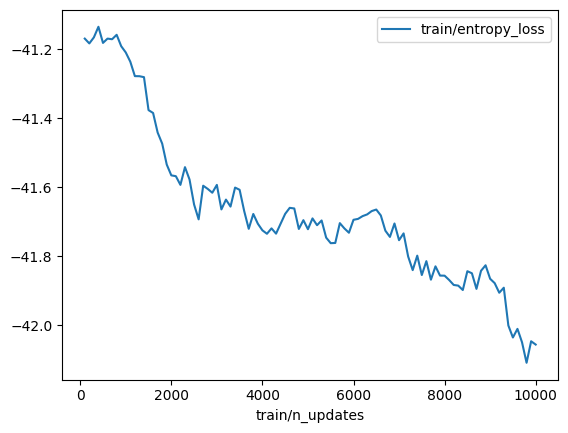

In [ ]:
%matplotlib inline
df_a2c.plot(x="train/n_updates", y="train/entropy_loss")

### **TD3 agent**

In [ ]:
agent = DRLAgent(env = env_train)
TD3_params = {
    "batch_size": 100,
    "buffer_size": 1000000,
    "learning_rate": 0.001
}
model_td3 = agent.get_model("td3", model_kwargs=TD3_params)

if if_using_td3:
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
trained_td3 = agent.train_model(
    model = model_td3,
    tb_log_name = 'td3',
    total_timesteps = 50000
)if if_using_td3 else None

In [ ]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

### **PPO agent**

In [ ]:
agent = DRLAgent(env = env_train)
PPO_params = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128
}
model_ppo = agent.get_model("ppo", model_kwargs=PPO_params)

if if_using_ppo:
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [ ]:
trained_ppo = agent.train_model(
    model = model_ppo,
    tb_log_name = 'ppo',
    total_timesteps = 50000
)if if_using_ppo else None

In [ ]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

In [ ]:
agent = DRLAgent(env=env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
trained_ddpg = agent.train_model(
    model = model_ddpg,
    tb_log_name = 'ddpg',
    total_timesteps = 50000
)if if_using_ddpg else None

In [ ]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

--------------------------------------------------------------------------------

In [ ]:
from stable_baselines3 import A2C, PPO, SAC, TD3, DDPG

trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c")
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3")
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo")
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg")

e_test_gym = StockTradingEnv(
    df = df_test,
    turbulence_threshold = 70,
    risk_indicator_col = 'vix',
    **env_kwargs
)

In [ ]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=trained_a2c, environment=e_test_gym)
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(model=trained_td3, environment=e_test_gym)
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(model=trained_ppo, environment=e_test_gym)
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(model=trained_ddpg, environment=e_test_gym)

day: 334, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1429030.70
total_reward: 429030.70
total_cost: 1795.29
total_trades: 5381
Sharpe: 2.038
hit end!


In [ ]:
# df_actions_ppo

In [ ]:
df_account_value_a2c = df_account_value_a2c.set_index("date")
df_account_value_a2c.columns=["A2C"]
df_account_value_td3 = df_account_value_td3.set_index("date")
df_account_value_td3.columns=["TD3"]
df_account_value_ppo = df_account_value_ppo.set_index("date")
df_account_value_ppo.columns=["PPO"]
df_account_value_ddpg = df_account_value_ddpg.set_index("date")
df_account_value_ddpg.columns=["DDPG"]

#df_agents_results = pd.concat([df_account_value_a2c], axis=1)
df_agents_results = pd.concat([df_account_value_a2c, df_account_value_td3, df_account_value_ppo, df_account_value_ddpg], axis=1)
df_agents_results.index = pd.to_datetime(df_agents_results.index)
df_agents_results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,A2C
date,
2020-07-01,1.000000e+06
2020-07-02,1.000380e+06
2020-07-06,1.004846e+06
2020-07-07,9.976833e+05
2020-07-08,1.000619e+06
...,...
2021-10-21,1.432362e+06
2021-10-22,1.437443e+06
2021-10-25,1.439015e+06


/usr/local/lib/python3.10/dist-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.


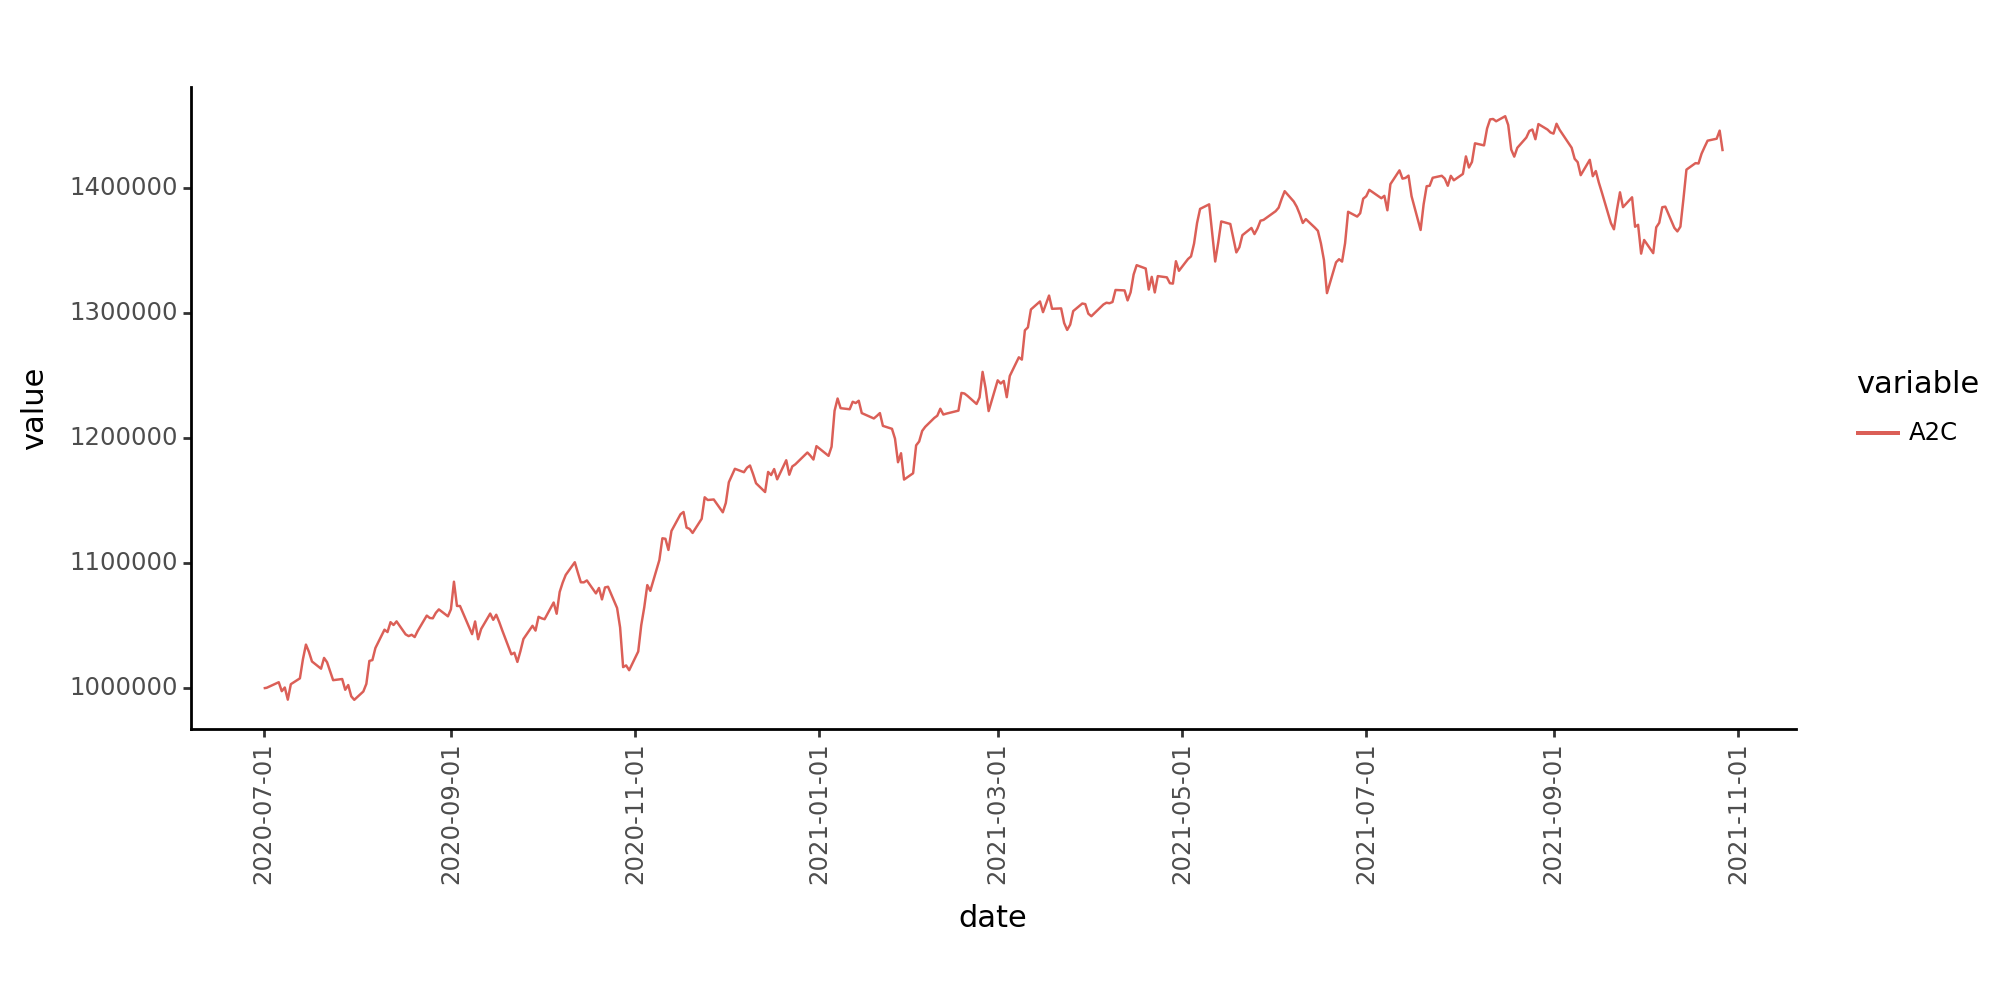

<Figure Size: (1000 x 500)>

In [ ]:
from plotnine import *
df_agents_results_plot = df_agents_results.reset_index().melt(id_vars="date")

p = ggplot(df_agents_results_plot, aes(x="date", y="value", color="variable")) + geom_line() + theme_classic() + theme(axis_text_x=element_text(rotation=90), aspect_ratio=0.4, figure_size=(10,5))
p

In [ ]:
df_dji = YahooDownloader(
    start_date=TRADE_START_DATE,
    end_date=TRADE_END_DATE,
    ticker_list=["dji"]
).fetch_data()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (319, 8)


In [ ]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')
dji

,close
date,
2020-07-01,1.000000e+06
2020-07-06,1.021449e+06
2020-07-07,1.006031e+06
2020-07-08,1.012912e+06
2020-07-09,9.988770e+05
...,...
2021-10-22,1.386322e+06
2021-10-25,1.388813e+06
2021-10-26,1.389427e+06
